In [27]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(100)

In [28]:
url <- "https://raw.githubusercontent.com/yxing6/DSCI_100_Project_Group4/main/data/of_8460_database.csv"
rock_data_raw <- read_csv(url)

Parsed with column specification:
cols(
  .default = col_character(),
  `Date Mapped (yyyy/mm/dd) *` = col_double(),
  `Lat Deg` = col_double(),
  `Long Deg` = col_double(),
  `UTM zone` = col_double(),
  Easting = col_double(),
  Northing = col_double(),
  `Method Precision (m)*` = col_double(),
  `Year *` = col_double(),
  `Lab Date` = col_double(),
  `GRAIN DEN Sample Value [g/cm3]` = col_double(),
  `DRY BULK DEN Sample Value [g/cm3]` = col_double(),
  `SAT BULK DEN Sample Value [g/cm3]` = col_double(),
  `POR Sample Value [%]` = col_double(),
  `MS Sample Value [SI A/m / A/m]` = col_double(),
  `NRM Sample Value [A/m]` = col_double(),
  `KN50 Sample Value` = col_double(),
  `Local Field [uT]` = col_double(),
  KN = col_double(),
  `RES Sample Value [Ohm.m]` = col_double(),
  `CHG Sample Value [ms]` = col_double()
)

See spec(...) for full column specifications.



In [31]:
borehole_data_raw <- rock_data_raw %>% 
    select("Location Type *", "MIRA Master Litho 1", "GRAIN DEN Sample Value [g/cm3]",
           "POR Sample Value [%]","MS Sample Value [SI A/m / A/m]",
           "NRM Sample Value [A/m]","RES Sample Value [Ohm.m]","CHG Sample Value [ms]") %>%
    rename("sample_type" = "Location Type *",
          "lithology" = "MIRA Master Litho 1",
           "density" = "GRAIN DEN Sample Value [g/cm3]",
           "porosity" = "POR Sample Value [%]",
           "MS" = "MS Sample Value [SI A/m / A/m]",
           "NRM" = "NRM Sample Value [A/m]",
           "RES" = "RES Sample Value [Ohm.m]",
           "chargeability" = "CHG Sample Value [ms]") %>%
    filter(lithology != "Other", sample_type == "Borehole") %>%
    mutate(sample_type = as_factor(sample_type), lithology = as_factor(lithology)) %>%
    select(-sample_type) %>%
    na.omit()
    
borehole_data_raw

lithology,density,porosity,MS,NRM,RES,chargeability
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Igneous,2.931,0.41,0.00118,0.029,7960,46.4
Igneous,2.770,0.28,0.07900,4.810,135000,19.5
Igneous,2.754,0.28,0.01260,0.352,51800,1.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Metamorphic,2.660,0.34,-7.08e-06,0.000162,18600,1.015
Metamorphic,2.791,0.16,1.68e-04,0.000401,27100,8.026
Metamorphic,2.811,0.36,7.39e-02,5.720000,437000,12.850


In [33]:
borehole_data_split <- initial_split(borehole_data_raw, prop = 0.75, strata = lithology)
data_train <- training(borehole_data_split)
data_test <- testing(borehole_data_split)


data_summary <- data_train %>%
    group_by(lithology) %>%
    summarize(n = n(), 
              across(density:chargeability, mean, na.rm = TRUE)) %>%
    rename(
        "lithology" = "lithology",
        "n" = "n",
        "mean_Density[g/cm3]" = "density",
        "mean_Porosity[%]" = "porosity",
        "mean_MS[m3/kg]" = "MS",
        "mean_NRM[A/m]" = "NRM",
        "mean_RES[Ohm.m]" = "RES",
        "mean_Chargeability[ms]" = "chargeability")

data_summary

data_train_log <- data_train %>%
    mutate(Density_log = log(density),
            Porosity_log = log(porosity), 
            NRM_log = log(NRM), 
            RES_log = log(RES), 
            Char_log = log(chargeability),
            MS_log = log(abs(MS)))%>%
    select("lithology","Density_log", "Porosity_log", "NRM_log", "RES_log", "Char_log","MS_log")
data_train_log 


`summarise()` ungrouping output (override with `.groups` argument)



lithology,n,mean_Density[g/cm3],mean_Porosity[%],mean_MS[m3/kg],mean_NRM[A/m],mean_RES[Ohm.m],mean_Chargeability[ms]
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Igneous,213,2.795094,2.4265728,0.0221646385,1.16394394,13140.345,10.963629
Metamorphic,559,2.768469,0.4516279,0.0017195424,0.45734268,9395.830,5.757408
Sedimentary,141,2.654787,6.1532624,0.0002734461,0.02431155,3764.348,3.977546


lithology,Density_log,Porosity_log,NRM_log,RES_log,Char_log,MS_log
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Igneous,1.0188473,-1.272966,1.570697,11.81303,2.9704145,-2.538307
Igneous,1.0130544,-1.272966,-1.044124,10.85515,0.4700036,-4.374058
Igneous,0.9991602,-1.272966,-1.158362,11.11543,2.6026897,-4.366153
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Metamorphic,0.9794533,-1.203973,-7.137168,10.08163,0.1475576,-9.340449
Metamorphic,1.0264000,-1.832581,-7.821549,10.20729,2.0826863,-8.691547
Metamorphic,1.0335403,-1.021651,1.743969,12.98769,2.5533438,-2.605042


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



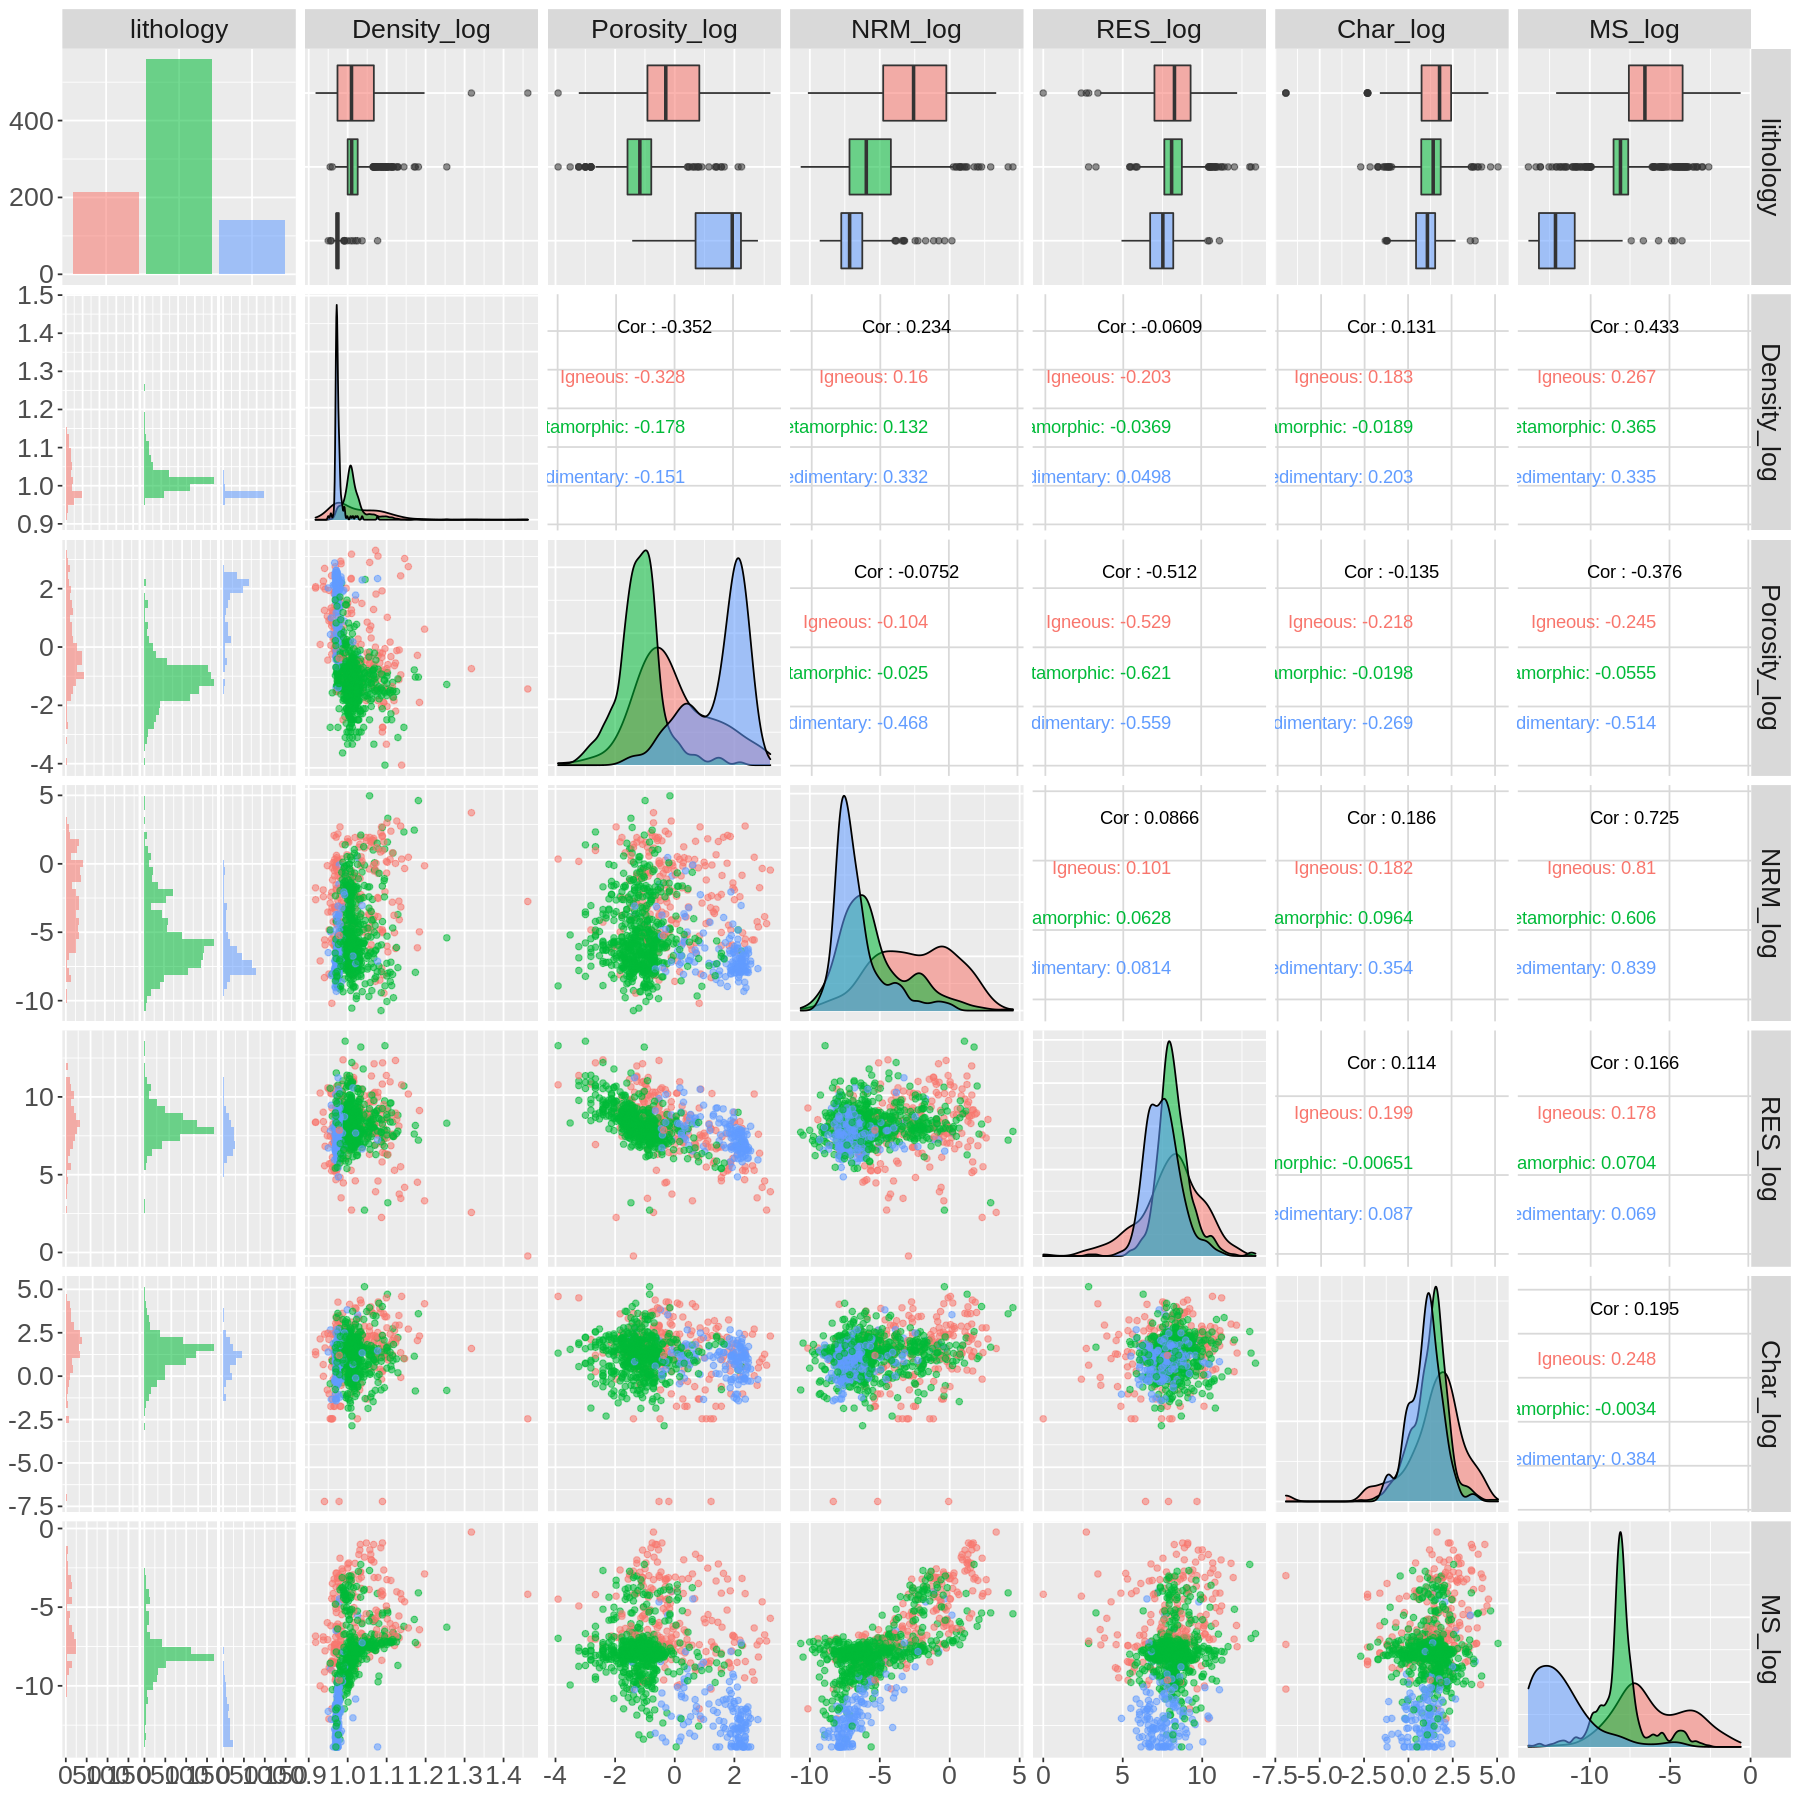

In [35]:
options(repr.plot.width = 15, repr.plot.height = 15)

# train_recipe_1 <- recipe(lithology ~ ., data = data_train_log) %>%
#          step_scale(all_predictors()) %>%
#          step_center(all_predictors())

# new_trained_1 <- train_recipe_1 %>% 
#     prep() %>%
#     bake(data_train_log)

train_pairs <- data_train_log %>%
    ggpairs(aes(colour = lithology, alpha=0.2)) + 
    theme(text = element_text(size = 20))
train_pairs


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,multiclass,0.8291076,5,0.008496252,Model15
11,accuracy,multiclass,0.8247299,5,0.007854456,Model11
12,accuracy,multiclass,0.8247177,5,0.010377548,Model12
⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,accuracy,multiclass,0.8137588,5,0.01056973,Model03
1,accuracy,multiclass,0.7863341,5,0.01448988,Model01
2,accuracy,multiclass,0.7863341,5,0.01448988,Model02


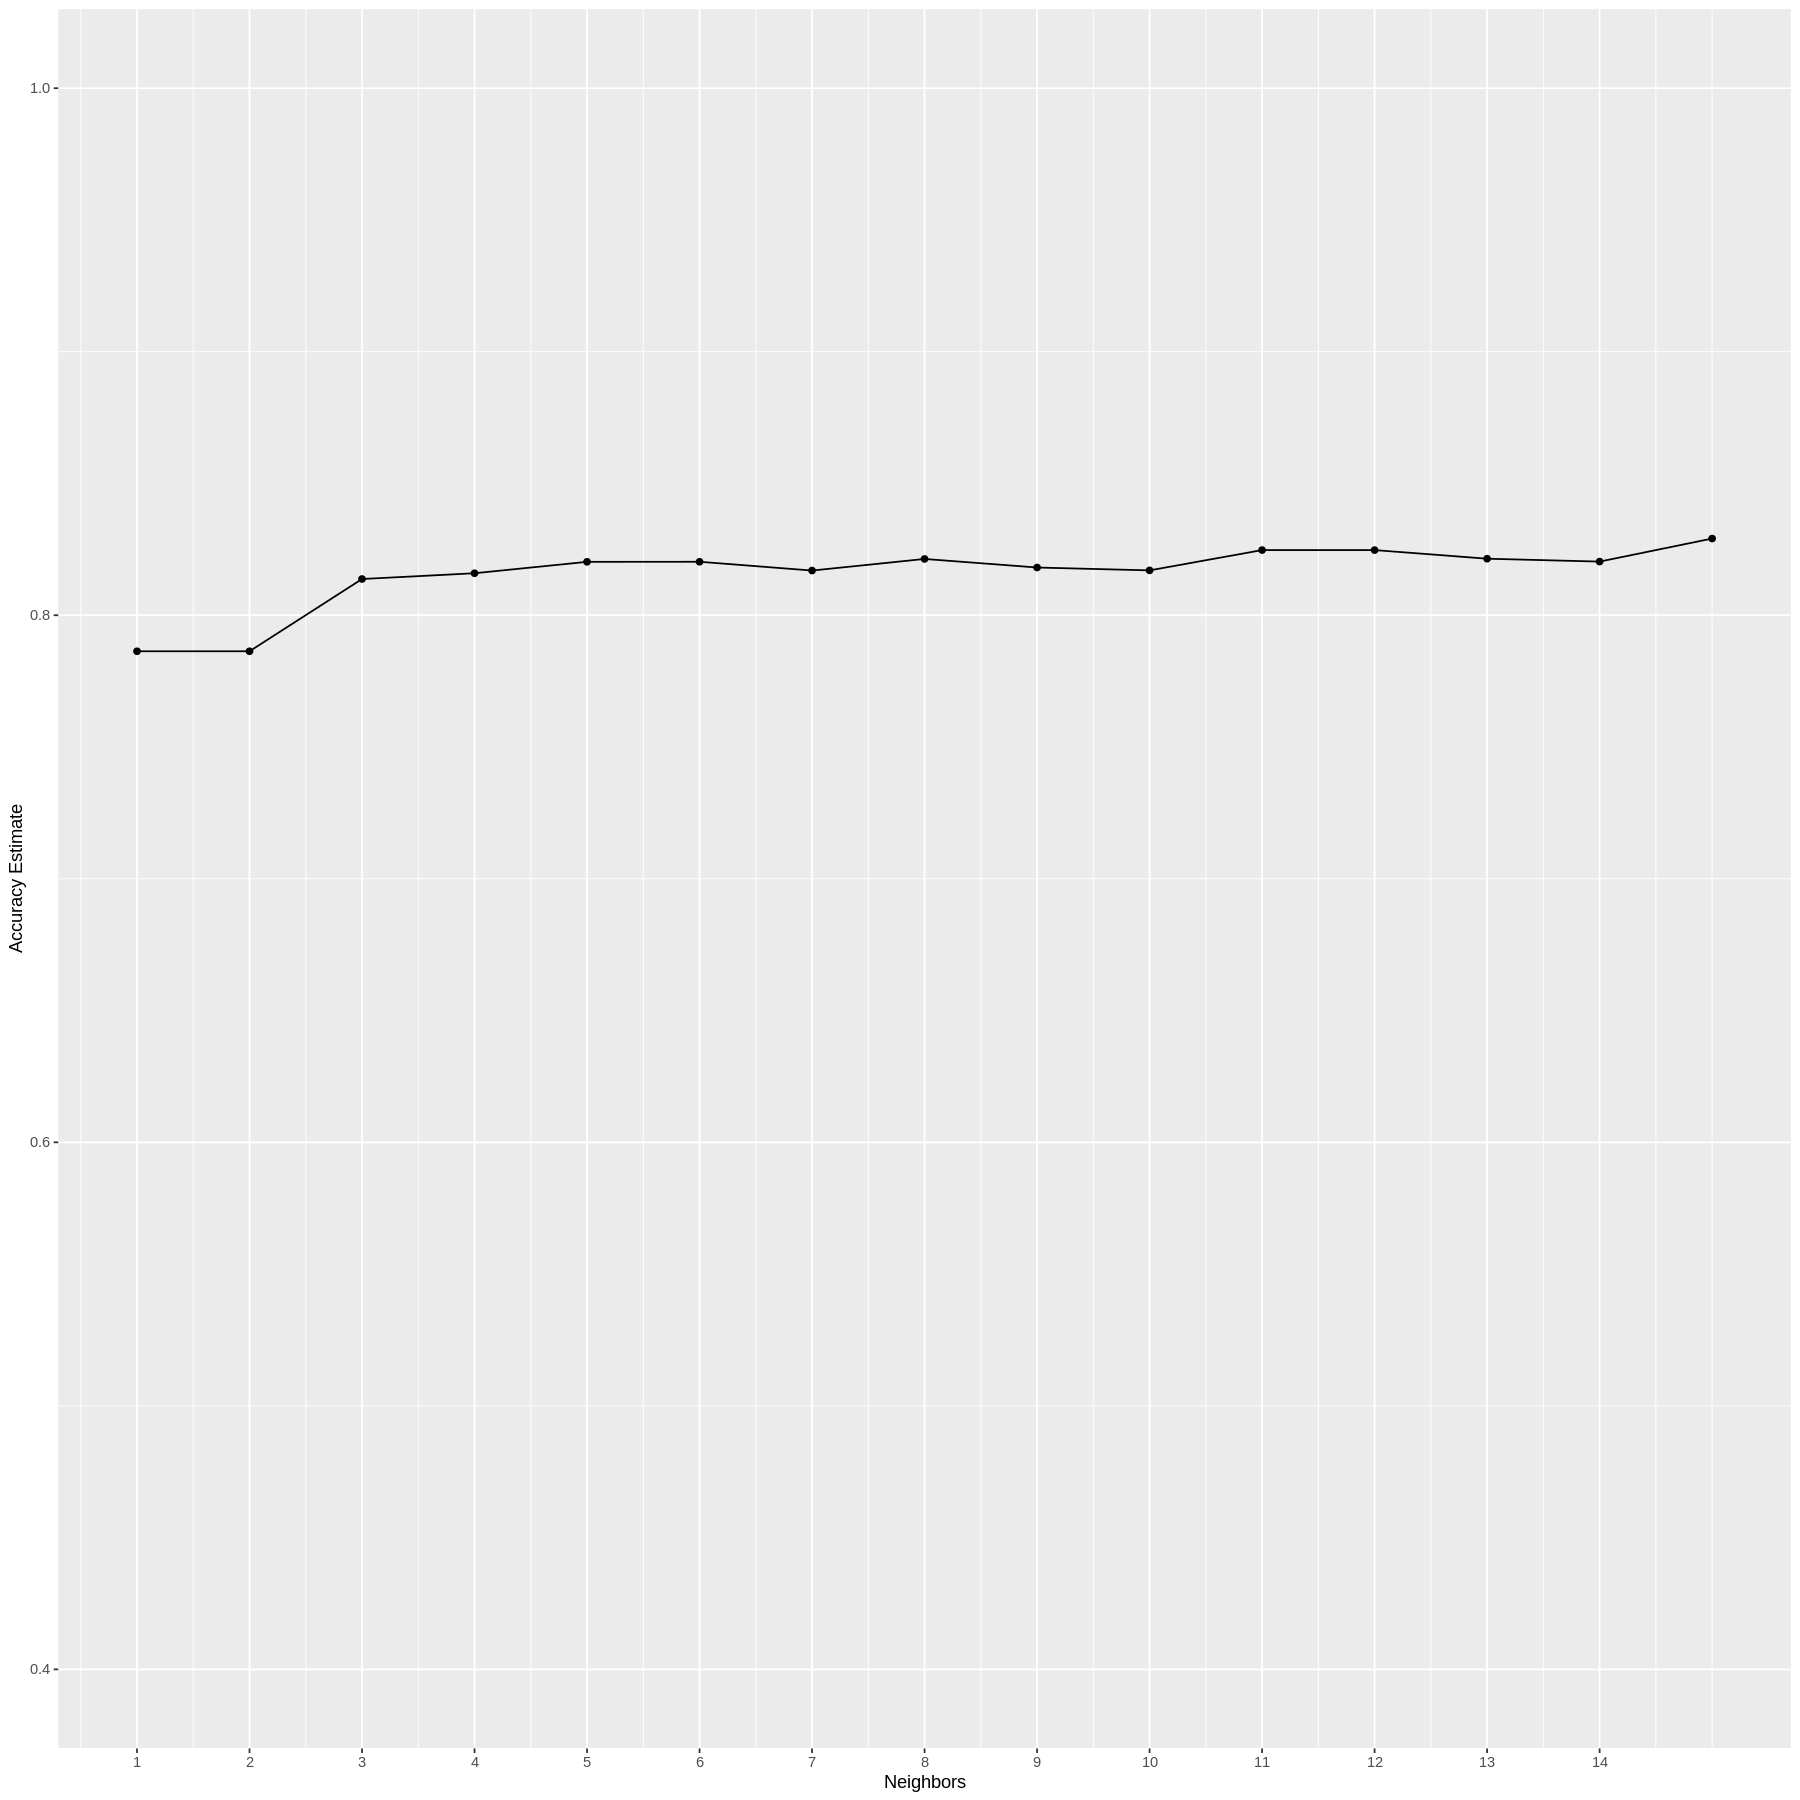

In [19]:
# train_recipe_2 <- recipe(lithology ~ MS+RES, data = data_train) %>%
#          step_log(all_predictors()) %>%
#          step_scale(all_predictors()) %>%
#          step_center(all_predictors())


# data_train%>%
# arrange(desc(MS))
# data_train_log


train_recipe_3 <- recipe(lithology ~ Porosity_log + MS_log, data = data_train_log) %>%
         step_scale(all_predictors()) %>%
         step_center(all_predictors())


# training_vfold <- vfold_cv(data_train, v = 5, strata = lithology)

training_vfold <- vfold_cv(data_train_log, v = 5, strata = lithology)
k_vals <- tibble(neighbors = seq(1, 15))

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

# knn_results <- workflow() %>%
#        add_recipe(train_recipe_2) %>%
#        add_model(knn_tune) %>%
#        tune_grid(resamples = training_vfold, grid = k_vals) %>%
#        collect_metrics()


knn_results_1 <- workflow() %>%
       add_recipe(train_recipe_3) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples = training_vfold, grid = k_vals) %>%
       collect_metrics()
# knn_results_1

accuracies <- knn_results_1 %>% 
      filter(.metric == "accuracy") %>%
        arrange(desc(mean))
accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k





### we will pick K = 6

In [20]:

knn_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
       set_engine("kknn") %>%
       set_mode("classification")

rock_model <- workflow() %>%
       add_recipe(train_recipe_3) %>%
       add_model(knn_final) %>%
       fit(data = data_train_log)

rock_model 

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~6, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1664841
Best kernel: rectangular
Best k: 6

In [21]:
data_test_log <- data_test %>%
    mutate(Density_log = log(density),
            Porosity_log = log(porosity), 
            NRM_log = log(NRM), 
            RES_log = log(RES), 
            Char_log = log(chargeability),
            MS_log = log(abs(MS)))%>%
    select("lithology","Density_log", "Porosity_log", "NRM_log", "RES_log", "Char_log","MS_log")
data_test_log 

lithology,Density_log,Porosity_log,NRM_log,RES_log,Char_log,MS_log
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Igneous,0.9612641,-0.3285041,-7.3416199,8.565983,0.9162907,-9.631935
Igneous,1.0310470,-1.0788097,1.0919233,9.752665,2.5336968,-1.725972
Igneous,1.0777291,-1.0788097,-0.9571127,10.165852,1.8718022,-3.405205
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Metamorphic,0.9681239,1.5644405,-6.592945,5.455321,-0.67530726,-9.301360
Metamorphic,1.0006319,0.1133287,-9.753345,6.661855,2.08765770,-8.611504
Metamorphic,0.9783261,-1.0788097,-8.727914,9.830917,0.01488861,-11.858237


In [25]:
rock_prediction <- predict(rock_model, data_test_log) %>% bind_cols(data_test_log)
rock_prediction

prediction_accuracy <- rock_prediction %>% 
    metrics(truth = lithology, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

prediction_accuracy

prediction_confusion <- rock_prediction %>%
             conf_mat(truth = lithology, estimate = .pred_class)
prediction_confusion

.pred_class,lithology,Density_log,Porosity_log,NRM_log,RES_log,Char_log,MS_log
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Metamorphic,Igneous,0.9612641,-0.3285041,-7.3416199,8.565983,0.9162907,-9.631935
Igneous,Igneous,1.0310470,-1.0788097,1.0919233,9.752665,2.5336968,-1.725972
Igneous,Igneous,1.0777291,-1.0788097,-0.9571127,10.165852,1.8718022,-3.405205
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Metamorphic,Metamorphic,0.9681239,1.5644405,-6.592945,5.455321,-0.67530726,-9.301360
Metamorphic,Metamorphic,1.0006319,0.1133287,-9.753345,6.661855,2.08765770,-8.611504
Metamorphic,Metamorphic,0.9783261,-1.0788097,-8.727914,9.830917,0.01488861,-11.858237


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8278146


             Truth
Prediction    Igneous Metamorphic Sedimentary
  Igneous          38          16           2
  Metamorphic      28         169           1
  Sedimentary       4           1          43